In [1]:
import ot
import time
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)


c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

In [3]:
n_dim = 14
n_classes = 13
n_datasets = 4
device = 'cpu'

## Creating Dataset

In [4]:
def make_dataset(mean, cov, v=None, separation=1, n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(n_dim,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [5]:
# Creating datasets
mu = np.array([0]*n_dim)

true_features = []
true_labels = []

separation = 6
angles = [0, 15, 30, 45]
Xs, Ys = [], []
for i in range(n_datasets - 1):
    A = np.random.randn(n_dim, n_dim)
    cov = .25 * np.dot(A.T, A) + np.eye(n_dim)
    v = np.array([np.cos((np.pi / 180) * angles[i]), np.sin((np.pi / 180) * angles[i])] * (n_dim//2) + [np.cos((np.pi / 180) * angles[i])] * (n_dim%2))
    X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
    true_features.append(X)
    true_labels.append(y)
    
    Xs.append(torch.from_numpy(X).float())
    Ys.append(torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=n_classes).float())

In [6]:
A = np.random.randn(n_dim, n_dim)
cov = .1 * np.dot(A.T, A) + np.eye(n_dim)
v = np.array([np.cos((np.pi / 180) * angles[-1]), np.sin((np.pi / 180) * angles[-1])] * (n_dim//2) + [np.cos((np.pi / 180) * angles[-1])] * (n_dim%2))
X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
Xt_tr = torch.from_numpy(X).float()
Yt_tr = torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float()
true_features.append(X)
true_labels.append(y)

In [7]:
x_minima, x_maxima = [], []
y_minima, y_maxima = [], []

for features in true_features:
    x_minima.append(features[:, 0].min())
    x_maxima.append(features[:, 0].max())
    
    y_minima.append(features[:, 1].min())
    y_maxima.append(features[:, 1].max())
    
xmin, xmax = np.amin(x_minima), np.amax(x_maxima)
ymin, ymax = np.amin(y_minima), np.amax(y_maxima)

print(xmin, xmax, ymin, ymax)

-5.553009276718781 8.647034180200835 -8.972382858010361 8.02722484849336


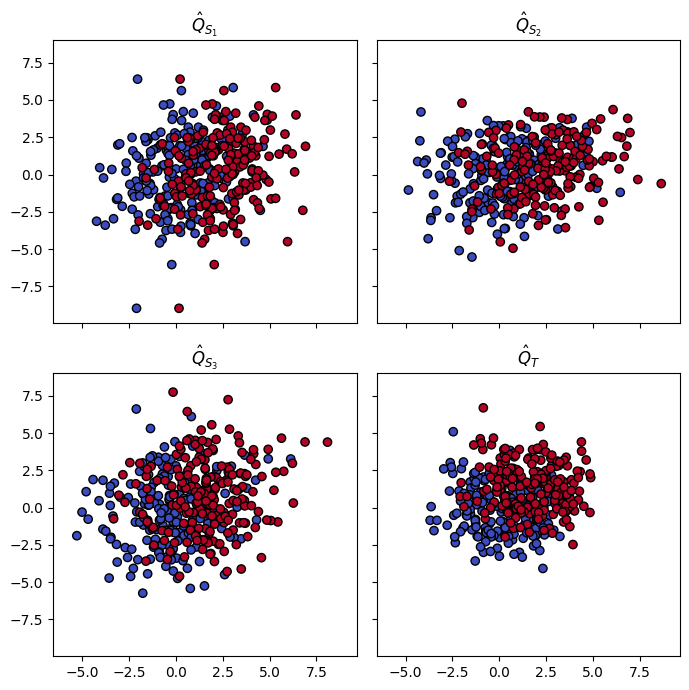

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(true_features[:-1], true_labels[:-1], axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
        
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

ax = axes.flatten()[-1]
Xi = true_features[-1]
Yi = true_labels[-1]
# ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c='gray', edgecolor='k')
ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

In [9]:
demo_datasets = [(Xsk, Ysk) for Xsk, Ysk in zip(Xs, Ys)] + [(Xt_tr, None)]

## 

## Importing CSTR dataset

In [4]:
CSTR_data = np.load('./data/cstr_acfmeandata.npy')
CSTR_features = CSTR_data[:, :-4]
CSTR_labels = CSTR_data[:, -4]
CSTR_domains = CSTR_data[:, -3]
n_domains = int(np.max(CSTR_domains)) + 1
true_features = [CSTR_features[:1300, :]] + [CSTR_features[1300+i*260:1300+(i+1)*260, :] for i in range(n_domains-1)]
true_labels = [CSTR_labels[:1300]] + [CSTR_labels[1300+i*260:1300+(i+1)*260] for i in range(n_domains-1)]

sources_features = [torch.from_numpy(CSTR_features[:1300, :]).float()] + [torch.from_numpy(CSTR_features[1300+i*260:1300+(i+1)*260, :]).float() for i in range(n_domains-1)]

sources_labels = [torch.nn.functional.one_hot(torch.from_numpy(CSTR_labels[:1300]).long(), num_classes=-1).float()] \
                +[torch.nn.functional.one_hot(torch.from_numpy(CSTR_labels[1300+i*260:1300+(i+1)*260]).long(), num_classes=-1).float() for i in range(n_domains-1)]
# Data set with labels for sources
CSTR_datasets = [(Xsk, Ysk) for Xsk, Ysk in zip(sources_features[:-1], sources_labels[:-1])] + [(sources_features[-1], None)]
# Dataset without labels
#datasets = [(Xsk, None) for Xsk, Ysk in zip(sources_features[:-1], sources_labels[:-1])] + [(sources_features[-1], None)]

In [5]:
datasets = CSTR_datasets

## Wasserstein Barycenters

Here we implement Algorithm 1 of our paper, whose pseudo-code is as follows,

![Labeled Wasserstein Barycenter](./algorithm1.png)

In [12]:
def wasserstein_barycenter(XP,
                           YP=None,
                           XB=None,
                           YB=None,
                           weights=None,
                           n_samples=None,
                           n_iter_max=10,
                           tol=1e-9,
                           verbose=False,
                           inner_verbose=False,
                           propagate_labels=False,
                           penalize_labels=False):
    if n_samples is None and XB is None:
        # If number of points is not provided,
        # assume that the support of the barycenter
        # has sum(nsi) where si is the i-th source
        # domain.
        n_samples = int(np.sum([len(XPk) for XPk in XP]))
    
    if YP is None:
        if propagate_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                             " for 'propagate_labels' = True"))
        if penalize_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                              " for 'penalize_labels' = True"))
    else:
        n_classes = YP[0].shape[1]
    dtype = XP[0].dtype
    device = XP[0].device

    if weights is None:
        weights = unif(len(XP), device=device, dtype=dtype)

    it = 0
    comp_start = time.time()

    # Initializes Features
    if XB is None:
        XB = torch.randn(n_samples, XP[0].shape[1])

    # Initializes Labels
    if propagate_labels and YB is None:
        yB = torch.from_numpy(
            np.random.randint(low=0,
                              high=n_classes,
                              size=n_samples)).long()
        YB = torch.nn.functional.one_hot(
            yB, num_classes=n_classes).float()

    # Displacement of points in the support
    delta = tol + 1
    last_loss = np.inf
    # Create uniform weights
    u_P = [torch.ones(len(XPk), device=device) / len(XPk) for XPk in XP]
    u_B = torch.ones(len(XB), device=device) / len(XB)

    while (delta > tol and it < n_iter_max):
        # NOTE: Here we solve the barycenter problem without calculating
        # gradients at each iteration, as per the envelope theorem, we
        # only need to compute gradients at optimality.
        with torch.no_grad():
            C, ot_plans = [], []

            for k in range(len(XP)):
                C_k = torch.cdist(XP[k], XB, p=2) ** 2
                if penalize_labels:
                    C_k += C_k.detach().max() * torch.cdist(YP[k], YB, p=2) ** 2
                plan_k = ot.emd(u_P[k], u_B, C_k)
                C.append(C_k)
                ot_plans.append(plan_k.to(dtype))
            XB = sum([
                w_k * n_samples * torch.mm(plan_k.T, XP_k)
                for w_k, plan_k, XP_k in zip(weights, ot_plans, XP)
            ])
            if propagate_labels:
                YB = sum([
                    w_k * n_samples * torch.mm(plan_k.T, YP_k)
                    for w_k, plan_k, YP_k in zip(weights, ot_plans, YP)
                ])
            loss = sum([
                torch.sum(C_k * plan_k) for C_k, plan_k in zip(C, ot_plans)
            ])
            delta = torch.norm(loss - last_loss) / n_samples
            last_loss = loss

            it += 1
    # Re-evaluate the support at optimality for calculating the gradients
    # NOTE: now we define the support while holding its gradients w.r.t. the
    # weight vector and eventually the support.
    XB = sum([
        w_k * n_samples * torch.mm(plan_k.T, XP_k)
        for w_k, plan_k, XP_k in zip(weights, ot_plans, XP)
    ])
    if propagate_labels:
        YB = sum([
            w_k * n_samples * torch.mm(plan_k.T, YP_k)
            for w_k, plan_k, YP_k in zip(weights, ot_plans, YP)
        ])
        return XB, YB
    return XB

## Dictionary Learning

In this section we train our dictionary using labeled source domain data, and unlabeled target domain data. The pseudo-code for DaDiL is as follows,

![DaDiL Learning Loop](./algorithm2.png)

### Hyper Parameters

In [13]:
lr = 1e-1
n_iter_max = 20
n_samples = 13*100
batch_size = 260
n_components = 3
batches_per_it = n_samples // batch_size
spc = n_samples // n_classes
spc_batches = batch_size // n_classes

### Optimization variables definition

First, we need to create the variables that we will optimize. In our paper, we parametrize empirical distributions through their support, i.e.,

$$\hat{P}_{k}(\mathbf{x},\mathbf{y}) = \dfrac{1}{n}\sum_{i=1}^{n}\delta((\mathbf{x}, \mathbf{y})-(\mathbf{x}_{i}^{(P_{k})}, \mathbf{y}_{i}^{(P_{k})}))$$

where $\mathbf{x} \in \mathbb{R}^{d}$ is a feature vector, and $\mathbf{y} \in \Delta_{n_{c}}$ is a vector containing the probability of a sample belonging to class $c=1,\cdots,n_{c}$.

In [14]:
XP = torch.nn.ParameterList([
    torch.nn.parameter.Parameter(data=torch.randn(n_samples, n_dim), requires_grad=True)
    for _ in range(n_components)
])

In [15]:
YP_init = []
for _ in range(n_components):
    ypk = torch.cat(
        [torch.tensor([c] * spc)
         for c in range(n_classes)]
    ).long()
    YPk = torch.nn.functional.one_hot(ypk,
                                      num_classes=n_classes)
    YP_init.append(YPk)

In [16]:
YP = torch.nn.ParameterList([
    torch.nn.parameter.Parameter(data=yp.float(),
                                 requires_grad=True)
    for yp in YP_init]
)

In [17]:
A0 = torch.ones(n_datasets, n_components) / 4

A = torch.nn.parameter.Parameter(data=A0, requires_grad=True)

In [18]:
optimizer = torch.optim.Adam([*XP, *YP, A], lr=lr)

### Loss Definition

Now, let us analyze the loss function of DaDiL,

If $\hat{Q}_{\ell}$ is labeled:

$$\mathcal{L}(\hat{Q}_{\ell},\hat{B}_{\ell}) = W_{c}(\hat{Q}_{\ell},\hat{B}_{\ell})$$

otherwise,

$$W_{2}(\hat{Q}_{\ell},\hat{B}_{\ell}).$$

Naturally, the source domains are labeled so the first option is used. The last option is used on the target domain. If labels are available, we compute a __supervised__ Wasserstein distance, which ground-cost,

$$C_{ij} = \lVert \mathbf{x}_{i}^{(P)} - \mathbf{x}_{j}^{(Q)} \rVert_{2}^{2} + \beta\lVert \mathbf{y}_{i}^{(P)} - \mathbf{y}_{j}^{(Q)} \rVert_{2}^{2}$$

otherwise, we calculate a standard $W_{2}$ between $P$ and $Q$. This is defined below,

In [19]:
class JointWassersteinDistance(torch.nn.Module):
    def __init__(self):
        super(JointWassersteinDistance, self).__init__()

    def forward(self, XQ, YQ, XP, YP, index=None):
        a = torch.ones(XP.shape[0], device=XP.device) / XP.shape[0]
        b = torch.ones(XQ.shape[0], device=XQ.device) / XQ.shape[0]
        CX = torch.cdist(XP, XQ, p=2) ** 2

        if YP is not None and YQ is not None:
            CY = torch.cdist(YP, YQ, p=2) ** 2
        else:
            CY = torch.zeros_like(CX)

        label_weight = CX.detach().max()

        C = CX + label_weight * CY
        with torch.no_grad():
            # NOTE: We DO NOT backpropagate through
            #       the OT plan.
            plan = ot.emd(a, b, C)
        return torch.sum(C * plan)

In [20]:
criterion = JointWassersteinDistance()

### Learning Loop

In [21]:
fit_history = {
    'weights': [],
    'loss': [],
    'atoms_features': [],
    'atoms_labels': []
}

In [22]:
for it in range(n_iter_max):
    pbar = tqdm(range(batches_per_it))
    avg_it_loss = 0.0
    for _ in pbar:
        optimizer.zero_grad()
        
        loss = 0.0
        for l, ((XQl, YQl), al) in enumerate(zip(datasets, A)):
            # Samples a minibatch from XQl
            if YQl is None:
                indices = np.random.choice(np.arange(len(XQl)), size=batch_size)
                minibatch_XQl = XQl[indices]
                minibatch_YQl = None
            else:
                yQl = YQl.argmax(dim=1)
                indices = []
                for c in range(n_classes):
                    ind = np.random.choice(np.where(yQl == c)[0], size=spc_batches)
                    indices.append(ind)
                indices = np.concatenate(indices)
                minibatch_XQl = XQl[indices]
                minibatch_YQl = YQl[indices].softmax(dim=1)
                
            # Samples a minibatch from each XP
            minibatch_XP = []
            minibatch_YP = []
            for XPk, YPk in zip(XP, YP):
                yPk = YPk.argmax(dim=1)
                indices = []
                for c in range(n_classes):
                    ind = np.random.choice(np.where(yPk == c)[0], size=spc_batches)
                    indices.append(ind)
                indices = np.concatenate(indices)
                
                minibatch_XP.append(XPk[indices])
                minibatch_YP.append(YPk[indices].softmax(dim=1))
                
            # Calculates a Wasserstein Barycenter
            propagate_labels = True
            if propagate_labels:
                minibatch_XBl, minibatch_YBl = wasserstein_barycenter(
                XP=minibatch_XP,
                YP=minibatch_YP,
                XB=None,
                YB=None,
                weights=al,
                n_samples=batch_size,
                n_iter_max=10,
                tol=1e-9,
                verbose=False,
                inner_verbose=False,
                propagate_labels=propagate_labels,
                penalize_labels=True)

            else:
                minibatch_XBl, minibatch_YBl = wasserstein_barycenter(
                    XP=minibatch_XP,
                    YP=None,
                    XB=None,
                    YB=None,
                    weights=al,
                    n_samples=batch_size,
                    n_iter_max=10,
                    tol=1e-9,
                    verbose=False,
                    inner_verbose=False,
                    propagate_labels=propagate_labels,
                    penalize_labels=False), None
                
            loss_l = criterion(minibatch_XQl,
                            minibatch_YQl,
                            minibatch_XBl,
                            minibatch_YBl)
            loss += loss_l
            
        # Backprop
        loss.backward()
        
        # Optimization Step
        optimizer.step()
        
        # project weights back into the simplex
        with torch.no_grad():
            A.data = ot.utils.proj_simplex(A.data.T).T
        
        # Save it for logging
        avg_it_loss += loss.item() / batches_per_it
    # Save vars for plotting
    fit_history['weights'].append(A.data.detach().clone())
    fit_history['loss'].append(avg_it_loss)
    fit_history['atoms_features'].append([XPk.data.detach().clone() for XPk in XP])
    fit_history['atoms_labels'].append([YPk.data.detach().clone() for YPk in YP])
    print(f'It {it+1} out of {n_iter_max}. Loss: {avg_it_loss}')

100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


It 1 out of 20. Loss: 22.304516983032222


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


It 2 out of 20. Loss: 15.799892997741697


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


It 3 out of 20. Loss: 8.922822380065918


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


It 4 out of 20. Loss: 4.750109577178955


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


It 5 out of 20. Loss: 2.645992660522461


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


It 6 out of 20. Loss: 1.718597936630249


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


It 7 out of 20. Loss: 1.1879833459854126


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


It 8 out of 20. Loss: 0.853671097755432


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


It 9 out of 20. Loss: 0.6043210744857788


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


It 10 out of 20. Loss: 0.44332305192947385


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


It 11 out of 20. Loss: 0.31760173439979555


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


It 12 out of 20. Loss: 0.24020340144634245


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


It 13 out of 20. Loss: 0.1921692728996277


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


It 14 out of 20. Loss: 0.15472556054592132


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


It 15 out of 20. Loss: 0.12745215594768525


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


It 16 out of 20. Loss: 0.1053122639656067


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


It 17 out of 20. Loss: 0.09835438430309296


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


It 18 out of 20. Loss: 0.09323084801435472


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


It 19 out of 20. Loss: 0.08250380158424378


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

It 20 out of 20. Loss: 0.08035223633050918


Now, let us analyze how the different $\alpha_{\ell}$ evolve throughout training,

In [23]:
XP = [XPk.detach() for XPk in XP]
YP = [YPk.detach() for YPk in YP]
A = A.detach()

we can fit a classifier (in this case, a SVM) on each atom, that is, we find,
$$\hat{h}_{k} = \text{argmin}_{h\in\mathcal{H}}\hat{\mathcal{R}}_{P_{k}}(h)$$

In [24]:
classifiers = []
for X_atom, Y_atom in zip(XP, YP):
    y_atom = Y_atom.argmax(axis=1)
    
    classifiers.append(SVC(kernel='linear', probability=True).fit(X_atom, y_atom))

Naturally, one may use $\alpha \in \Delta_{K}$ for weighting predictions of atom classifiers. We weight the $\hat{h}_{k}$'s using $\alpha_{T}$, which gives,

$$\hat{h}_{E}(\mathbf{x}^{(Q_{T})}_{j})=\sum_{k=1}^{K}\alpha_{T,k}\hat{h}_{k}(\mathbf{x}_{j}^{(Q_{T})}),$$

In [25]:
w = A[-1, :]
clf = SVC(kernel='linear', probability=True)
predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(true_features[-1])
    print("Atom {} w/ weight {} got {}".format(k, np.round(w[k], 3), accuracy_score(true_labels[-1], yp)))

    P = clf.predict_proba(true_features[-1])
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', w, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(true_labels[-1], yp)

Atom 0 w/ weight 0.34599998593330383 got 0.5576923076923077
Atom 1 w/ weight 0.32199999690055847 got 0.5346153846153846
Atom 2 w/ weight 0.3310000002384186 got 0.5615384615384615


In [26]:
accuracy_e

0.6230769230769231

Now, let us reconstruct the target domain using a Wasserstein barycenter. This corresponds to iterating,

$$\hat{\mathbf{x}}^{(B_{T})}_{i} = \sum_{k}\alpha_{T,k}T_{\pi^{(k)}}(\mathbf{x}_{i}^{(B_{T})}) = n\sum_{k}\alpha_{T,k}\sum_{j=1}^{n}\pi_{i,j}^{(k)}\mathbf{x}_{j}^{(P_{k})}$$

$$\hat{\mathbf{y}}^{(B_{T})}_{i} = \sum_{k}\alpha_{T,k}T_{\pi^{(k)}}(\mathbf{y}_{i}^{(B_{T})}) = n\sum_{k}\alpha_{T,k}\sum_{j=1}^{n}\pi_{i,j}^{(k)}\mathbf{y}_{j}^{(P_{k})}$$

Until convergence (see Algorithm 1 in the paper).

In [27]:
Xr, Yr = wasserstein_barycenter(
                XP=XP,
                YP=YP,
                XB=None,
                YB=None,
                weights=A[-1, :],
                n_samples=len(true_features[-1]),
                n_iter_max=10,
                tol=1e-9,
                verbose=False,
                inner_verbose=False,
                propagate_labels=True,
                penalize_labels=True)

We use t-SNE to compare the reconstructed target domain with the true target domain in 2 dimensions

In [28]:
tsne = TSNE(n_components=2, random_state=0)
Xtrue_tsne = tsne.fit_transform(true_features[-1])
Xr_tsne = tsne.fit_transform(Xr)


Text(0.5, 1.0, 'Reconstructed data in dim 2 with t-SNE')

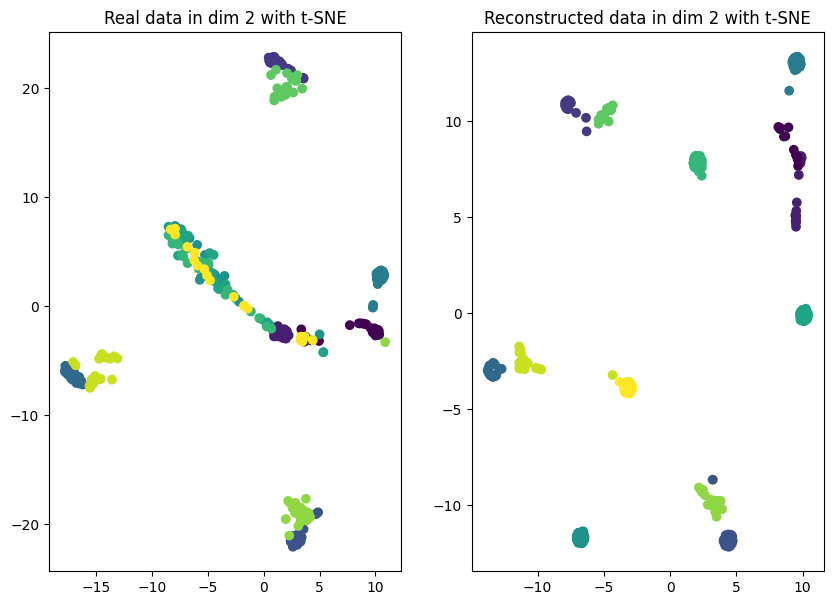

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (10, 7))

ax[0].scatter(x=Xtrue_tsne[:, 0], y=Xtrue_tsne[:, 1], c=true_labels[-1])
ax[0].set_title('Real data in dim 2 with t-SNE')
ax[1].scatter(x=Xr_tsne[:, 0], y=Xr_tsne[:, 1], c=Yr.argmax(dim=1))
ax[1].set_title('Reconstructed data in dim 2 with t-SNE')


using the labeled samples generated on the target domain, we can find a classifier, defined by,

$$\hat{h}_{R} = \text{argmin}_{h\in\mathcal{H}}\hat{\mathcal{R}}_{B_{T}}(h) = \dfrac{1}{n}\sum_{i=1}^{n}\mathcal{L}(h(\mathbf{x}_{i}^{(B_{T})}),y_{i}^{(B_{T})})$$

In [30]:
hR = SVC(kernel='linear').fit(Xr, Yr.argmax(dim=1))

In [31]:
y_pred = hR.predict(true_features[-1])
y_true = true_labels[-1]
accuracy_r =  accuracy_score(y_pred, y_true)
accuracy_r

0.5192307692307693

## Classification without domain adaptation

In [8]:
#clf = SVC(kernel='linear').fit(CSTR_features[:-260, :], CSTR_labels[:-260])
clf = RandomForestClassifier(criterion = 'log_loss').fit(CSTR_features[:-260, :], CSTR_labels[:-260])
y_pred = clf.predict(CSTR_features[-260:, :])
accuracy_score(y_pred, CSTR_labels[-260:])

0.7846153846153846

## Domain distributions

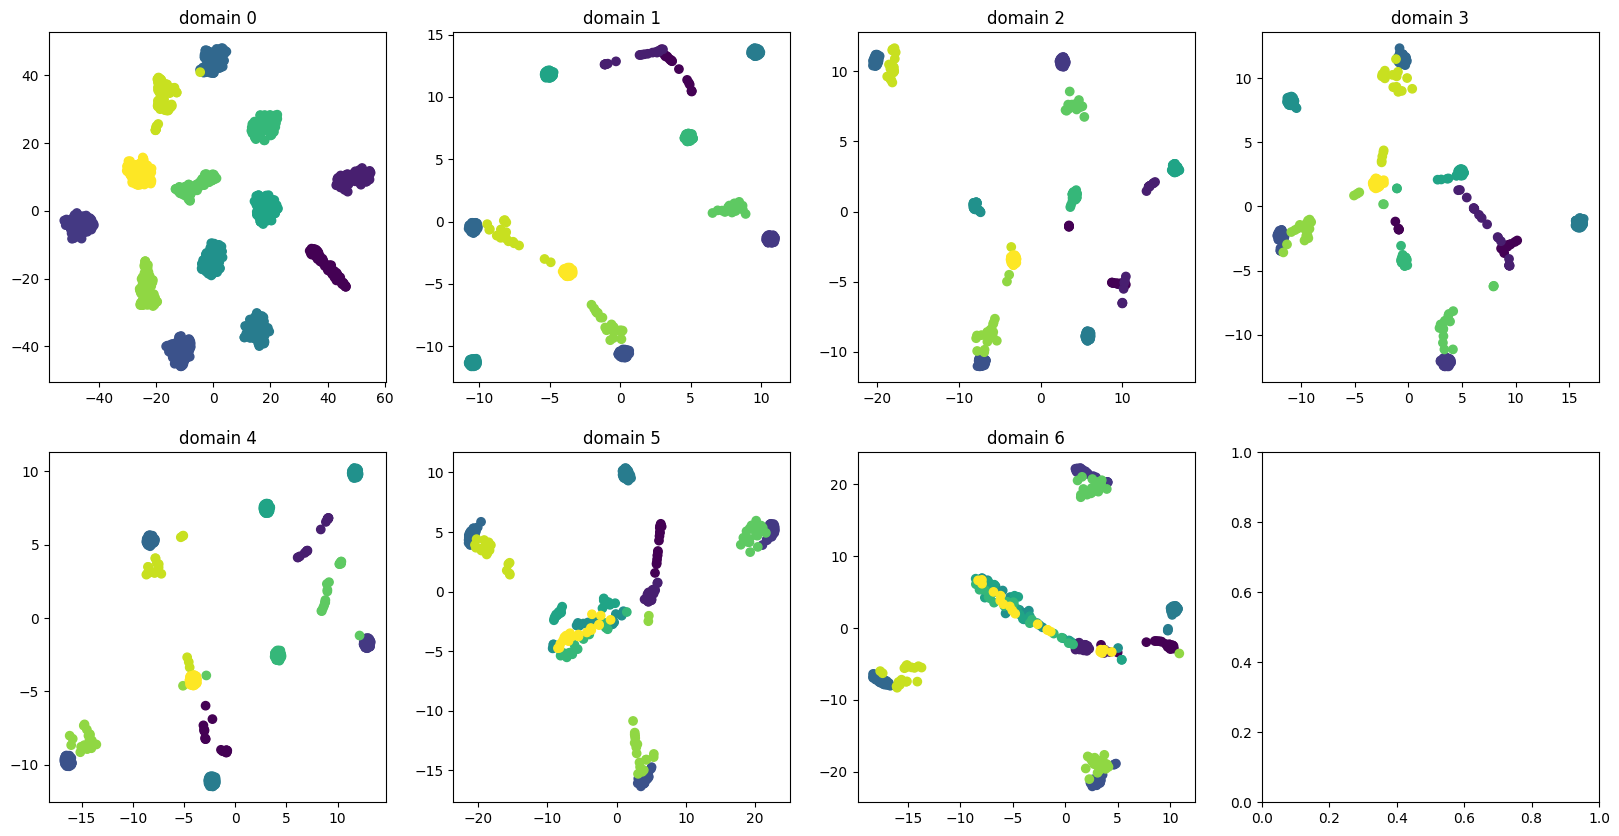

In [33]:
tsne = TSNE(n_components=2, random_state=0)
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
axes = ax.flatten()

for i in range(7):
    sources_features_tsne = sources_features[i]
    sources_labels_tsne = sources_labels[i]
    X_tsne = tsne.fit_transform(sources_features_tsne)
    axes[i].scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], c=sources_labels_tsne.argmax(dim=1))
    axes[i].set_title('domain {}'.format(i))